In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks
# from torchattacks import PGD, FGSM

from tqdm.notebook import tqdm

### Define device type

In [2]:
# define device type - cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device == torch.device("cuda") else {}

### Load MNIST data

In [3]:
def load_MNIST_data(train_batch_size, test_batch_size, kwargs):
    mnist_transform = transforms.Compose([transforms.ToTensor()])

    mnist_train_data = TVdatasets.MNIST(root='../data', 
                                        train=True,
                                        transform=mnist_transform,
                                        download=True)

    mnist_test_data = TVdatasets.MNIST(root='../data',
                                      train=False,
                                      transform=mnist_transform,
                                      download=True)

    print("Number of train samples:", len(mnist_train_data))
    print("Number of test samples:", len(mnist_test_data))
    
    trainloader = torch.utils.data.DataLoader(dataset=mnist_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=mnist_test_data,
                                            batch_size=test_batch_size,
                                            shuffle=False,
                                            **kwargs)
    
    return trainloader, testloader

### Model class

In [4]:
class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5), # 16*24*24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 32*20*20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 32*10*10
            nn.Conv2d(32,64,5), # 64*6*6
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

### Adversarial Training

In [5]:
def adversarial_training(model, trainloader, attack, num_epochs, stepsize):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=stepsize)

    num_batches = len(trainloader)
    loss_lst = []

    for epoch in range(num_epochs):
        for itr, (batch_imgs, batch_labels) in enumerate(tqdm(trainloader)):
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            batch_adv_imgs = attack(batch_imgs, batch_labels)

            X_train = torch.cat((batch_adv_imgs, batch_imgs), 0)
            Y_train_gt = torch.cat((batch_labels, batch_labels), 0)
            Y_train_pred = model(X_train)

            loss_val = loss(Y_train_pred, Y_train_gt)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if itr % 100 == 0:
                print("Epoch [{}/{}], Iteration [{}/{}], Loss:{}".format(epoch+1, num_epochs, 
                                                                            itr+1, num_batches, 
                                                                            round(loss_val.item(),4)))

            loss_lst.append(loss_val.item())
    
    plt.figure(figsize=(10,7))
    plt.plot(loss_lst)
    plt.xlabel("iteration")
    plt.ylabel("objective function")
    plt.grid()
    plt.show()

### Load model and data

In [6]:
train_batch_size = 32
test_batch_size = 32

model = CNN_net().to(device)

trainloader, testloader = load_MNIST_data(train_batch_size, test_batch_size, kwargs)

Number of train samples: 60000
Number of test samples: 10000


### Define attack models

In [7]:
adv_eps = 0.3
adv_pgd_steps = 10

fgsm_attack = torchattacks.FGSM(model, eps=adv_eps)
pgd_attack = torchattacks.PGD(model, eps=adv_eps, alpha=0.1, steps=adv_pgd_steps)

### Adversarial Training

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/5], Iteration [1/1875], Loss:2.3253
Epoch [1/5], Iteration [101/1875], Loss:1.3409
Epoch [1/5], Iteration [201/1875], Loss:1.0017
Epoch [1/5], Iteration [301/1875], Loss:0.8727
Epoch [1/5], Iteration [401/1875], Loss:0.8061
Epoch [1/5], Iteration [501/1875], Loss:0.4769
Epoch [1/5], Iteration [601/1875], Loss:0.539
Epoch [1/5], Iteration [701/1875], Loss:0.4961
Epoch [1/5], Iteration [801/1875], Loss:0.6227
Epoch [1/5], Iteration [901/1875], Loss:0.4629
Epoch [1/5], Iteration [1001/1875], Loss:0.3478
Epoch [1/5], Iteration [1101/1875], Loss:0.1655
Epoch [1/5], Iteration [1201/1875], Loss:0.2317
Epoch [1/5], Iteration [1301/1875], Loss:0.2244
Epoch [1/5], Iteration [1401/1875], Loss:0.406
Epoch [1/5], Iteration [1501/1875], Loss:0.2275
Epoch [1/5], Iteration [1601/1875], Loss:0.0979
Epoch [1/5], Iteration [1701/1875], Loss:0.1775
Epoch [1/5], Iteration [1801/1875], Loss:0.0802


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/5], Iteration [1/1875], Loss:0.203
Epoch [2/5], Iteration [101/1875], Loss:0.1178
Epoch [2/5], Iteration [201/1875], Loss:0.266
Epoch [2/5], Iteration [301/1875], Loss:0.0706
Epoch [2/5], Iteration [401/1875], Loss:0.1599
Epoch [2/5], Iteration [501/1875], Loss:0.1807
Epoch [2/5], Iteration [601/1875], Loss:0.2747
Epoch [2/5], Iteration [701/1875], Loss:0.2472
Epoch [2/5], Iteration [801/1875], Loss:0.1505
Epoch [2/5], Iteration [901/1875], Loss:0.0854
Epoch [2/5], Iteration [1001/1875], Loss:0.0813
Epoch [2/5], Iteration [1101/1875], Loss:0.1713
Epoch [2/5], Iteration [1201/1875], Loss:0.0372
Epoch [2/5], Iteration [1301/1875], Loss:0.204
Epoch [2/5], Iteration [1401/1875], Loss:0.1797
Epoch [2/5], Iteration [1501/1875], Loss:0.0305
Epoch [2/5], Iteration [1601/1875], Loss:0.0816
Epoch [2/5], Iteration [1701/1875], Loss:0.2789
Epoch [2/5], Iteration [1801/1875], Loss:0.1558


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/5], Iteration [1/1875], Loss:0.1696
Epoch [3/5], Iteration [101/1875], Loss:0.0572
Epoch [3/5], Iteration [201/1875], Loss:0.0665
Epoch [3/5], Iteration [301/1875], Loss:0.1244
Epoch [3/5], Iteration [401/1875], Loss:0.0411
Epoch [3/5], Iteration [501/1875], Loss:0.1221
Epoch [3/5], Iteration [601/1875], Loss:0.2533
Epoch [3/5], Iteration [701/1875], Loss:0.0555
Epoch [3/5], Iteration [801/1875], Loss:0.0402
Epoch [3/5], Iteration [901/1875], Loss:0.2162
Epoch [3/5], Iteration [1001/1875], Loss:0.0385
Epoch [3/5], Iteration [1101/1875], Loss:0.1789
Epoch [3/5], Iteration [1201/1875], Loss:0.114
Epoch [3/5], Iteration [1301/1875], Loss:0.3347
Epoch [3/5], Iteration [1401/1875], Loss:0.0974
Epoch [3/5], Iteration [1501/1875], Loss:0.0392
Epoch [3/5], Iteration [1601/1875], Loss:0.0241
Epoch [3/5], Iteration [1701/1875], Loss:0.3064
Epoch [3/5], Iteration [1801/1875], Loss:0.1532


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/5], Iteration [1/1875], Loss:0.054
Epoch [4/5], Iteration [101/1875], Loss:0.1103
Epoch [4/5], Iteration [201/1875], Loss:0.1138
Epoch [4/5], Iteration [301/1875], Loss:0.1357
Epoch [4/5], Iteration [401/1875], Loss:0.0731
Epoch [4/5], Iteration [501/1875], Loss:0.0193
Epoch [4/5], Iteration [601/1875], Loss:0.0318
Epoch [4/5], Iteration [701/1875], Loss:0.0595
Epoch [4/5], Iteration [801/1875], Loss:0.081
Epoch [4/5], Iteration [901/1875], Loss:0.089
Epoch [4/5], Iteration [1001/1875], Loss:0.1308
Epoch [4/5], Iteration [1101/1875], Loss:0.0442
Epoch [4/5], Iteration [1201/1875], Loss:0.1202
Epoch [4/5], Iteration [1301/1875], Loss:0.0808
Epoch [4/5], Iteration [1401/1875], Loss:0.0801
Epoch [4/5], Iteration [1501/1875], Loss:0.0545
Epoch [4/5], Iteration [1601/1875], Loss:0.0247
Epoch [4/5], Iteration [1701/1875], Loss:0.1354
Epoch [4/5], Iteration [1801/1875], Loss:0.2322


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/5], Iteration [1/1875], Loss:0.0737
Epoch [5/5], Iteration [101/1875], Loss:0.202
Epoch [5/5], Iteration [201/1875], Loss:0.0707
Epoch [5/5], Iteration [301/1875], Loss:0.1004
Epoch [5/5], Iteration [401/1875], Loss:0.0386
Epoch [5/5], Iteration [501/1875], Loss:0.0222
Epoch [5/5], Iteration [601/1875], Loss:0.088
Epoch [5/5], Iteration [701/1875], Loss:0.1196
Epoch [5/5], Iteration [801/1875], Loss:0.0335
Epoch [5/5], Iteration [901/1875], Loss:0.0433
Epoch [5/5], Iteration [1001/1875], Loss:0.2375
Epoch [5/5], Iteration [1101/1875], Loss:0.0279
Epoch [5/5], Iteration [1201/1875], Loss:0.0105
Epoch [5/5], Iteration [1301/1875], Loss:0.0944
Epoch [5/5], Iteration [1401/1875], Loss:0.0289
Epoch [5/5], Iteration [1501/1875], Loss:0.072
Epoch [5/5], Iteration [1601/1875], Loss:0.2045
Epoch [5/5], Iteration [1701/1875], Loss:0.0847
Epoch [5/5], Iteration [1801/1875], Loss:0.0156


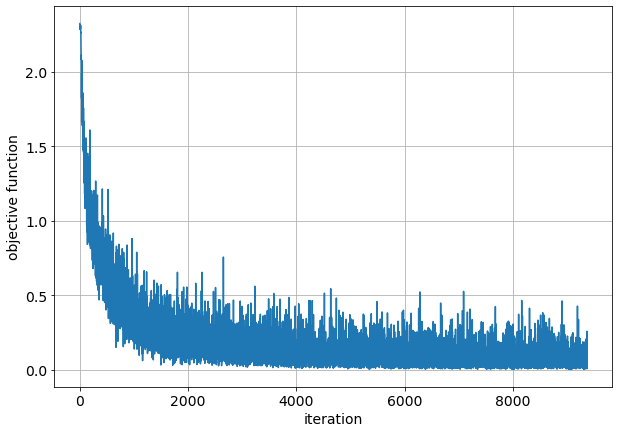

In [8]:
adversarial_training(model, trainloader, pgd_attack, num_epochs=5, stepsize=1e-3)

### Test accuracy (standard clean)

In [9]:
num_samples = 0
num_corr_pred = 0
model.eval()

with torch.no_grad():
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
        X_test = batch_imgs.to(device)
        Y_test_gt = batch_labels.to(device)

        _, Y_test_pred = torch.max(model(X_test), dim=1)
    #     print(Y_test_gt.shape, Y_test_pred.shape)

        num_samples += batch_imgs.shape[0]
        num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Standard clean accuracy: {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean accuracy: 99.19 %


### Test accuracy (PGD attack)

In [10]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test = pgd_attack(batch_imgs, batch_labels)
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (PGD attack): 94.73 %


### Test accuracy (FGSM attack)

In [11]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_test = fgsm_attack(batch_imgs, batch_labels)
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM attack): 96.93 %


### Test accuracy (FGSM + PGD - attack)

In [12]:
num_samples = 0
num_corr_pred = 0
model.eval()

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
    
    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)
    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)
    
    X_test = torch.cat((X_adv_fgsm_imgs, X_adv_pgd_imgs), 0)
    Y_test_gt = torch.cat((batch_labels, batch_labels), 0)
    
    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += Y_test_gt.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM + PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM + PGD attack): 95.785 %
